In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
print(os.path.abspath(os.curdir))

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm
from scipy import signal as sg
# from sklearn.utils import shuffle

from src import cnn_model_delay as cnn_delay

import rfcutils.ofdm_helper_fn_short as ofdmfn

import rfcutils # this corresponds to utility functions provided for the challenge

get_sinr = lambda s, i: 10*np.log10(np.mean(np.abs(s)**2)/np.mean(np.abs(i)**2))
get_pow = lambda s: np.mean(np.abs(s)**2)

2022-08-19 14:16:36.779959: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


---

In [3]:
def eval_qpsk_demod(sig_est, sig_true, start_idx):
    qpsk_sig_idx = 16 - start_idx%16
    bit_est = rfcutils.matched_filter_demod(sig_est[qpsk_sig_idx:])
    bit_true = rfcutils.matched_filter_demod(sig_true[qpsk_sig_idx:])
    ber = np.sum(bit_est != bit_true)/len(bit_true)
    assert len(bit_est) == len(bit_true)
    return ber

def eval_sigs(sig_est, sig_true, start_idx):
    mse = get_pow(sig_est - sig_true)
    mse_db = 10*np.log10(mse)
    sdr = get_sinr(sig_true, sig_est-sig_true)
    ber = eval_qpsk_demod(sig_est, sig_true, start_idx)
    return (mse, mse_db, sdr, ber)

## Load Models

In [4]:
long_k_sz = 100
window_len_sync = 640
model_name = f'sync_mixture_OFDM64_CP16_QPSK_sig_len{window_len_sync}_K{long_k_sz}_V2batch'
print(f'Training {model_name}')
# input_shape = all_sig_mixture_train_comp.shape[1:]
synch_model = cnn_delay.get_cnn_model_delay_new((window_len_sync, 2), vec_delays=80, k_sz=21, long_k_sz=long_k_sz)
synch_model.load_weights(f'trained_models/sync_OFDM_model/{model_name}')

Training sync_mixture_OFDM64_CP16_QPSK_sig_len640_K100_V2batch


2022-08-19 14:16:40.003911: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-19 14:16:40.004813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-19 14:16:40.100860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-19 14:16:40.100891: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-19 14:16:40.106427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-19 14:16:40.106473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

## Parameters

In [5]:
window_len = 40960
target_snr = 10

## Include Sync MMSE

In [6]:
random.seed(10)
np.random.seed(10)

sig_len = 400
core_vec_len = sig_len-80

qpsk_dataset, sync_qpsk_dataset, sync2_qpsk_dataset, all_start_idx1 = [], [], [], []
for idx in tqdm(range(10000)):
    sig1, _, _, _ = rfcutils.generate_qpsk_signal(sig_len//16)
    sig1_core = sig1[:core_vec_len]
    start_idx1 = 0
    
    qpsk_dataset.append(sig1) 
    sync_qpsk_dataset.append(sig1_core)
    all_start_idx1.append(start_idx1)


ofdm_dataset, sync_ofdm_dataset, sync2_ofdm_dataset, all_start_idx2 = [], [], [], []
for idx in tqdm(range(10000)):
    data, _, _ = ofdmfn.generate_ofdm_signal(56*(sig_len//80*2))
    start_idx2 = np.random.randint(len(data)-sig_len)
    sig2 = data[start_idx2:start_idx2+sig_len]
    

    s_idx = 80 - start_idx2%80
    sig2_core = sig2[s_idx:s_idx+core_vec_len]
    sig2_core_ext = data[0:sig_len]
    ofdm_dataset.append(sig2) 
    sync_ofdm_dataset.append(sig2_core)
    sync2_ofdm_dataset.append(sig2_core_ext)
    all_start_idx2.append(start_idx2)
 
qpsk_dataset = np.array(qpsk_dataset)
ofdm_dataset = np.array(ofdm_dataset)

sync_qpsk_dataset = np.array(sync_qpsk_dataset)
sync_ofdm_dataset = np.array(sync_ofdm_dataset)
sync2_ofdm_dataset = np.array(sync2_ofdm_dataset)

100%|██████████| 10000/10000 [00:19<00:00, 509.17it/s]


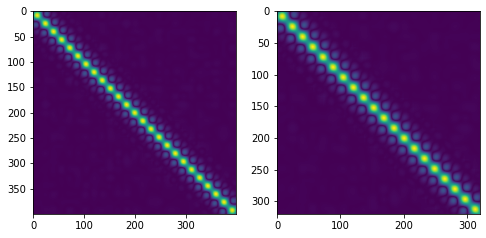

In [7]:
cov_qpsk = 1/np.shape(qpsk_dataset)[0]*np.matmul(qpsk_dataset.T, qpsk_dataset.conj())
cov_qpsk_sync = 1/np.shape(sync_qpsk_dataset)[0]*np.matmul(sync_qpsk_dataset.T, sync_qpsk_dataset.conj())
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(np.abs(cov_qpsk))
plt.subplot(122)
plt.imshow(np.abs(cov_qpsk_sync))
# plt.savefig(os.path.join("figures", f"QPSK_cov1.eps"), dpi=300)

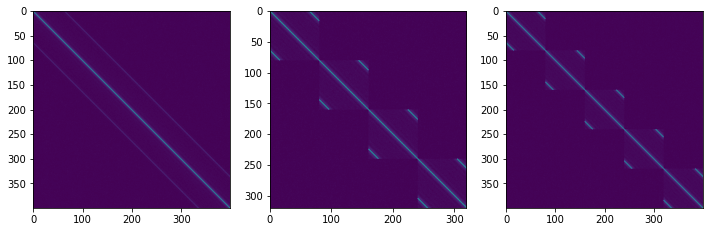

In [8]:
cov_ofdm = 1/np.shape(ofdm_dataset)[0]*np.matmul(ofdm_dataset.T, ofdm_dataset.conj())
cov_ofdm_sync = 1/np.shape(sync_ofdm_dataset)[0]*np.matmul(sync_ofdm_dataset.T, sync_ofdm_dataset.conj())
cov_ofdm_sync_ext = 1/np.shape(sync2_ofdm_dataset)[0]*np.matmul(sync2_ofdm_dataset.T, sync2_ofdm_dataset.conj())

plt.figure(figsize=(12,18))
plt.subplot(131)
plt.imshow(np.abs(cov_ofdm))
plt.subplot(132)
plt.imshow(np.abs(cov_ofdm_sync))
plt.subplot(133)
plt.imshow(np.abs(cov_ofdm_sync_ext))
# plt.savefig(os.path.join("figures", f"OFDM_cov1.eps"), dpi=300)


In [9]:
random.seed(42)
np.random.seed(42)
n_per_sinr = 1000
all_sinr = np.arange(-24,1.5,1.5)

all_sig_mixture, all_sig1, all_sig2, all_tau1, all_tau2 = [], [], [], [], []
for target_sinr in tqdm(all_sinr):
    for idx in range(n_per_sinr):
        data, _, _, _ = rfcutils.generate_qpsk_signal(sig_len//16)
        tau_s = 0
        sig1 = data[0:core_vec_len]
        
        data, _, _ = ofdmfn.generate_ofdm_signal(56*(window_len_sync//80*2))
        start_idx2 = np.random.randint(len(data)-window_len_sync)
        sig2 = data[start_idx2:start_idx2+core_vec_len]
        
        sig2_segT_sync = data[start_idx2:start_idx2+window_len_sync]
        sig2_bands_compT_sync = np.dstack((sig2_segT_sync.real, sig2_segT_sync.imag))
        tau_b = np.argmax(synch_model(sig2_bands_compT_sync[:,:window_len_sync,:]))
        
        coeff = np.sqrt(1/(10**(target_sinr/10)))
        
        sQ_Gauassian = np.empty(sig1.shape, dtype=np.complex128)
        sQ_Gauassian.real = np.random.normal(size=sig1.shape)/np.sqrt(2)
        sQ_Gauassian.imag = np.random.normal(size=sig1.shape)/np.sqrt(2)
        coeff_noise = np.sqrt(np.mean(np.abs(sig1)**2)/(np.mean(np.abs(sQ_Gauassian[:sig1.shape[0]])**2)*(10**(target_snr/10))))

        sig_mixture = sig1 + sig2 * coeff + sQ_Gauassian[:sig1.shape[0]]*coeff_noise
        all_sig_mixture.append(sig_mixture)
        all_sig1.append(sig1)
        all_sig2.append(sig2*coeff)
        
        all_tau1.append(tau_s)
        all_tau2.append(tau_b)
        
all_sig_mixture = np.array(all_sig_mixture)
all_sig1 = np.array(all_sig1)
all_sig2 = np.array(all_sig2)

  0%|          | 0/17 [00:00<?, ?it/s]2022-08-19 14:17:03.407349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-08-19 14:17:04.966347: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-19 14:17:05.048284: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-19 14:17:07.054832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-19 14:17:07.463316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
100%|██████████| 17/17 [01:47<00:00,  6.34s/it]


In [10]:
all_metric2 = []
# all_metric2B = []
nn_ber_mmse = []

snr = 10**(target_snr/10)
for iidx in tqdm(range(all_sig_mixture.shape[0])):
    # initial estimate
    sinr = 10**(all_sinr[iidx//n_per_sinr]/10)
    
    tau_s = all_tau1[iidx] % 16
    tau_b = all_tau2[iidx] % 80
    Css = cov_qpsk_sync.copy()
    Cbb = cov_ofdm_sync_ext[80-tau_b:80-tau_b+core_vec_len, 80-tau_b:80-tau_b+core_vec_len]
    Czz = np.identity(Cbb.shape[0])
#     Cbb[tau_b:tau_b+core_vec_len, :] = 0
#     Cbb[:,tau_b:tau_b+core_vec_len] = 0
#     Cbb[tau_b:tau_b+core_vec_len, tau_b:tau_b+core_vec_len] = cov_ofdm_sync
    scaled_Cbb = Cbb * 1/sinr + Czz *1/snr
    Cyy = Css + scaled_Cbb
    Csy = Css.copy()

#     Cyy_inv = np.linalg.pinv(Cyy,hermitian=True)
    U,S,Vh = np.linalg.svd(Cyy,hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(U[:,:sthr_idx], np.matmul(np.diag(1.0/(S[:sthr_idx])), U[:,:sthr_idx].conj().T))
    W = np.matmul(Csy,Cyy_inv)
    s_est = np.matmul(W, all_sig_mixture[iidx])
    nn_ber_mmse.append((eval_sigs(s_est, all_sig1[iidx], 0))[-1])

#     all_metric2.append(eval_sigs(s_est, all_sig1[iidx], all_tau1[iidx]))
    
#     s_map = rfcutils.modulate_qpsk_signal(rfcutils.matched_filter_demod(s_est))
#     all_metric2B.append(eval_sigs(s_map, all_sig1[iidx], all_tau1[iidx]))

100%|██████████| 17000/17000 [25:34<00:00, 11.08it/s]


(1e-05, 1)

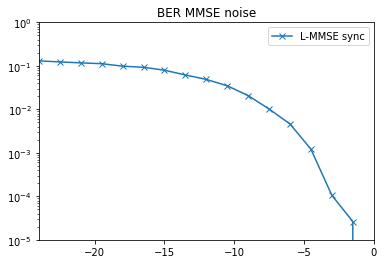

In [11]:
nsim = 1000
plt.figure()
SIR_values = np.arange(-24, 1.5, 1.5)
plt.semilogy(SIR_values,np.array(nn_ber_mmse).reshape(-1,nsim).mean(axis=-1), 'x-', label='L-MMSE sync')

plt.legend()
plt.title("BER MMSE noise")
plt.xlim(xmax = 0, xmin = -24)
plt.ylim(ymax = 1, ymin = 1e-5)
# plt.savefig(f'MMSE_noisy_{target_snr}.pdf')




## Save data in csv files

In [ ]:

ber_mmse_data = np.stack((SIR_values,np.array(nn_ber_mmse).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/ber_mmse_data_{target_snr}.csv', ber_mmse_data, delimiter=",")

from datetime import datetime
print(f'Data saved on {datetime.today()}')